# Modeling with linear regression

In this section, we will cover:

- fitting different linear repression models
- score analysis: MSE and variance explained: $R^2$
- residual analysis
- analysis of fitted values distribution
- most important features
- comparing the models: conclusions


In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('df_resample.csv')
df.head()

,symboling,make,fuel_type,aspiration,num_of_doors,body_style,drive_wheels,engine_location,wheel_base,length,...,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,1,mitsubishi,gas,std,four,sedan,fwd,front,96.3,172.4,...,122,2bbl,3.35,3.46,8.5,88.0,5000.0,25,32,6989.0
1,2,volkswagen,diesel,std,two,sedan,fwd,front,97.3,171.7,...,97,idi,3.01,3.40,23.0,52.0,4800.0,37,46,7775.0
2,0,bmw,gas,std,four,sedan,rwd,front,110.0,197.0,...,209,mpfi,3.62,3.39,8.0,182.0,5400.0,15,20,36880.0
3,1,mazda,gas,std,two,hatchback,fwd,front,93.1,159.1,...,91,2bbl,3.03,3.15,9.0,68.0,5000.0,30,31,5195.0
4,2,mitsubishi,gas,std,two,hatchback,fwd,front,93.7,157.3,...,92,2bbl,2.97,3.23,9.4,68.0,5500.0,31,38,6189.0


In [3]:
X = df.copy()
X.drop('price', axis=1, inplace=True)
y = np.log(df.price) # as discussed, we are going to use the log transform here

## Train-test split

To validate out model, lets split the data on train and test sets, so we can evaluate the predictions on the test set later.


In [4]:
# now the split in a stratified way
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.3, random_state=95276
)


## Categories

In [5]:
from sklearn.preprocessing import OneHotEncoder
import pickle

with open('category_list', 'rb') as file:
    cat_cols = pickle.load(file)

# numeric columns
num_cols = [col for col in X_train.columns if col not in cat_cols]
num_cols

['wheel_base',
 'length',
 'width',
 'height',
 'curb_weight',
 'engine_size',
 'bore',
 'stroke',
 'compression_ratio',
 'horsepower',
 'peak_rpm',
 'city_mpg',
 'highway_mpg']

## Feature Selection

This is the proper way of fitting a OLS model: carefully choosing which feature will be included into the model, because:

- including unnecessary features (that are correlated to the features already in the model) increases the standard error of the coefficients
- excluding necessary features results in bias

So lets chose only numeric features which are correlated to the price:


In [6]:
X_train['price'] = y_train
cols = num_cols + ['price']
cor = X_train[cols].corr().abs()
cor.loc[cor.price > .7, 'price'].sort_values()

C:\Users\BJ571WQ\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


length         0.778576
city_mpg       0.796573
highway_mpg    0.797305
width          0.798628
horsepower     0.839862
engine_size    0.856983
curb_weight    0.892790
price          1.000000
Name: price, dtype: float64

In [7]:
mask = (cor.price > .7 ) & (cor.price < 1)
correlated = cor[mask].sort_values(by='price').index
not_correlated = [col for col in num_cols if col not in correlated]

print('correlated: ', correlated)
print('not correlated: ', not_correlated)

correlated:  Index(['length', 'city_mpg', 'highway_mpg', 'width', 'horsepower',
       'engine_size', 'curb_weight'],
      dtype='object')
not correlated:  ['wheel_base', 'height', 'bore', 'stroke', 'compression_ratio', 'peak_rpm']


## Formula for OLS

In [8]:
cat_list = [f'C({cat})' for cat in cat_cols]
cat_formula = ' + '.join(cat_list)
num_formula = ' + '.join(correlated)

formula = f'price ~ {cat_formula} + {num_formula}'
formula

'price ~ C(make) + C(fuel_type) + C(aspiration) + C(num_of_doors) + C(body_style) + C(drive_wheels) + C(engine_location) + C(engine_type) + C(num_of_cylinders) + C(fuel_system) + C(symboling) + length + city_mpg + highway_mpg + width + horsepower + engine_size + curb_weight'

In [9]:
import statsmodels.formula.api as smf

model = smf.ols(formula=formula, data=X_train)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                     4107.
Date:                Sun, 28 Jun 2020   Prob (F-statistic):               0.00
Time:                        17:32:27   Log-Likelihood:                 6863.9
No. Observations:                7000   AIC:                        -1.362e+04
Df Residuals:                    6946   BIC:                        -1.325e+04
Df Model:                          53                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

## Model Scoring & Evaluation

In [10]:
r2 = res.rsquared_adj
print(f'R^2: {r2:.4}')

R^2: 0.9688


In [11]:
predictions = np.exp(res.predict(X_test)) # back transformation

mse = np.mean(
    (predictions - np.exp(y_test))**2
)
print(f'MSE: {mse:.4}')

MSE: 2.098e+06


In [12]:
data = {
    'model name': ['ols'],
    'r2': [r2],
    'MSE': [mse]
       }

score_df = pd.DataFrame(data)
score_df.to_csv('scores.csv')
score_df

,model name,r2,MSE
0,ols,0.968839,2.098474e+06


With an adjusted $R^2$ score of 0.9691 we can say that it is a really good model already!


## Feature selection through p-values

When we fit a linear regression model, we have to test the hypothesis that the evaluated coefficients for each regressor is actually zero.

In other words, we have:

- $H_0$: the coefficient is zero
- $H_1$ : the coefficient is not zero

Therefore, let's look into the p-values for each coefficient for each regressor to see if they shouldn't be zero:

*if a p-value of a given coefficient is larger than 5%, then we fail to reject the null hypothesis that the coefficient actually is zero*

However, all p-values here are smaller than 5%, so no additional feature selection will be done.

In [13]:
res.pvalues[res.pvalues>.05]
# we are not taking out make just because a few rotten apples

C(make)[T.mercedes-benz]        0.833019
C(num_of_cylinders)[T.three]    0.163597
C(symboling)[T.2]               0.796757
horsepower                      0.971511
dtype: float64

## Residual analysis

In a good model, what we should expect from the residuals:
- their mean should be zero
- they should be homoscedastic
- they should be normal
- they should have no correlation with the fitted values
- they should have no correlation with any of the features


### Residual mean

In [14]:
res.resid.mean() # good!

-4.826902052660183e-13

### Residuals vs fitted values

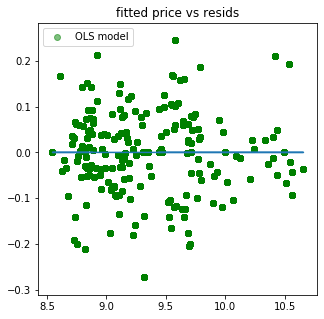

In [15]:
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt

%matplotlib inline

plt.figure(figsize=(5, 5))
plt.title('fitted price vs resids')
plt.scatter(res.fittedvalues, res.resid, c="g", alpha=0.5, label="OLS model")
b, m = polyfit(res.fittedvalues, res.resid, 1)
plt.plot(res.fittedvalues, b + m * res.fittedvalues, '-')
plt.xlabel("")
plt.ylabel("")
plt.legend(loc=2)

### Correlation between residuals and $\hat y$

In a good model, residuals cannot be correlated to the fitted values. 

We have already saw before that the Ridge is ok in his regard:

In [16]:
from scipy.stats.stats import pearsonr
pearsonr(res.predict(X_train), res.resid)

(-8.759130573632312e-13, 0.9999999999451344)

## Most important features



In [17]:
index = res.pvalues[res.pvalues < .05].index
coefs = res.params[index]
df_coef_ols = pd.DataFrame({'coefs_abs': np.abs(np.round(coefs,2)),
                            'coef_value': np.round(coefs,2),
                            'feats': coefs.index})

df_coef_ols[~df_coef_ols.feats.str.startswith('make')].sort_values('coefs_abs', ascending=False).head(10)

,coefs_abs,coef_value,feats
Intercept,4.72,4.72,Intercept
C(fuel_system)[T.idi],2.47,2.47,C(fuel_system)[T.idi]
C(fuel_type)[T.gas],2.24,2.24,C(fuel_type)[T.gas]
C(fuel_system)[T.spfi],0.54,0.54,C(fuel_system)[T.spfi]
C(make)[T.isuzu],0.47,-0.47,C(make)[T.isuzu]
C(make)[T.bmw],0.31,0.31,C(make)[T.bmw]
C(num_of_cylinders)[T.five],0.30,-0.30,C(num_of_cylinders)[T.five]
C(engine_location)[T.rear],0.29,0.29,C(engine_location)[T.rear]
C(make)[T.audi],0.29,0.29,C(make)[T.audi]
C(num_of_cylinders)[T.four],0.27,-0.27,C(num_of_cylinders)[T.four]
